# Stacking base models to create one combined model


Now import all the `sklearn` packages that will be needed and our data sets.:

In [11]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv("my_full_data.csv")
df=df.drop('id',axis=1)

In [4]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [5]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

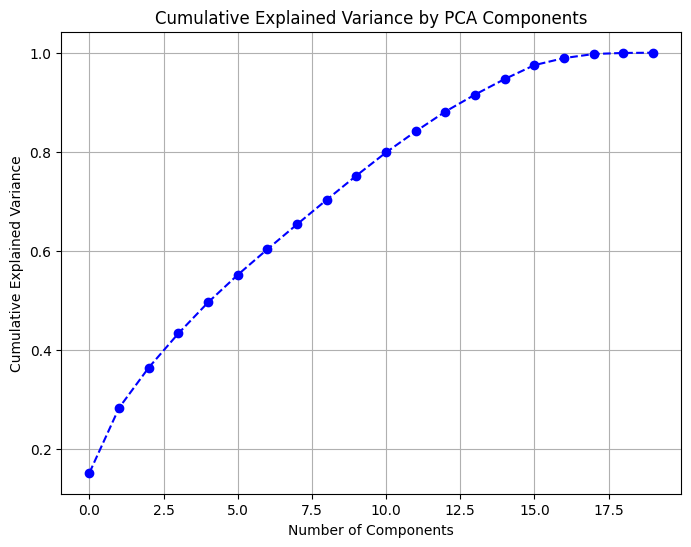

Number of components explaining 95% variance: 16


In [6]:
pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
n_components_pca = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Number of components explaining 95% variance: {n_components_pca}')

In [7]:
pca = PCA(n_components = 16)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
lda = LDA()
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

Take final models from everyone's individual exploration, and train them on the training data.

In [17]:
SVM = SVC(kernel='rbf',gamma=0.01,C=5,probability=True)
DecisionTree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, splitter = 'best', min_samples_split = 4, min_samples_leaf = 1, max_features = 20)
LogisticRegression = LogisticRegression(C=100, penalty='l1',max_iter=2000,solver= 'liblinear', tol=0.0001)
KNN = KNeighborsClassifier(leaf_size=20, n_neighbors=850, p=1, weights='distance')

In [28]:
SVM = SVM.fit(X_train_pca,y_train)

In [26]:
DecisionTree = DecisionTree.fit(X_train,y_train)


In [18]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
LogisticRegression = LogisticRegression.fit(X_train_resampled,y_train_resampled)


In [19]:
X_resampled2, y_resampled2 = ADASYN().fit_resample(X_train_lda, y_train)
KNN = KNN.fit(X_resampled2, y_resampled2)


## Creating the stacked model

First, we will make a list of all the base models that we are going to use.

In [20]:
base_classifiers = [
    ('DecisionTree', DecisionTree),
    ('LogisticRegression', LogisticRegression),
    ('KNN', KNN),
    ('SVM', SVM)
]

Now create the stacked model and fit to the training data. We can then measure its performance against the test data.

In [21]:
StackedModel = StackingClassifier(estimators = base_classifiers, cv=5, n_jobs=-1)

In [22]:
StackedModel = StackedModel.fit(X_train,y_train)
StackedModel

StackingClassifier(cv=5,
                   estimators=[('DecisionTree',
                                DecisionTreeClassifier(max_depth=4,
                                                       max_features=20,
                                                       min_samples_split=4)),
                               ('LogisticRegression',
                                LogisticRegression(C=100, max_iter=2000,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('KNN',
                                KNeighborsClassifier(leaf_size=20,
                                                     n_neighbors=850, p=1,
                                                     weights='distance')),
                               ('SVM', SVC(C=5, gamma=0.01, probability=True))],
                   n_jobs=-1)

In [23]:
ypred = StackedModel.predict(X_test)
ypred

array([1, 1, 1, ..., 1, 0, 1])

In [24]:
accuracy = accuracy_score(y_test, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, ypred))

Accuracy: 90.10%
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1107
           1       0.93      0.95      0.94      4117

    accuracy                           0.90      5224
   macro avg       0.86      0.84      0.85      5224
weighted avg       0.90      0.90      0.90      5224



## Plotting ROC curve for stacked and base models
We now plot an ROC curve so that we can compare how the stacked model has (or has not) made improvements from our base models.

In [29]:
yProbPred = StackedModel.predict_proba(X_test)
# printing an ROC curve

y_Pred_DecisionTree = DecisionTree.predict_proba(X_test)
y_Pred_LogisticRegression = LogisticRegression.predict_proba(X_test)
y_Pred_KNN = KNN.predict_proba(X_test_lda)
y_Pred_SVM = SVM.predict_proba(X_test_pca)

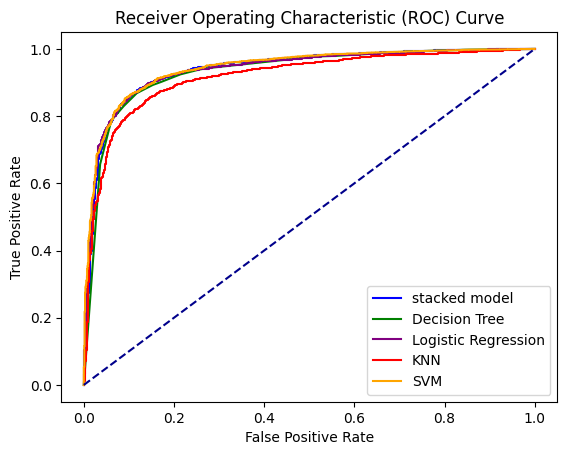

In [30]:

fprStacked, tprStacked, _ = metrics.roc_curve(y_test, yProbPred[:,1])
fprDecisionTree, tprDecisionTree, _ = metrics.roc_curve(y_test, y_Pred_DecisionTree[:,1])
fprLogisticRegression, tprLogisticRegression, _ = metrics.roc_curve(y_test, y_Pred_LogisticRegression[:,1])
fprKNN, tprKNN, _ = metrics.roc_curve(y_test, y_Pred_KNN[:,1])
fprSVM, tprSVM, _ = metrics.roc_curve(y_test, y_Pred_SVM[:,1])


plt.plot(fprStacked, tprStacked, color='blue', label = 'stacked model')
plt.plot(fprDecisionTree, tprDecisionTree, color='green', label = 'Decision Tree')
plt.plot(fprLogisticRegression, tprLogisticRegression, color='purple', label = 'Logistic Regression')
plt.plot(fprKNN, tprKNN, color='red', label = 'KNN')
plt.plot(fprSVM, tprSVM, color='orange', label = 'SVM')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

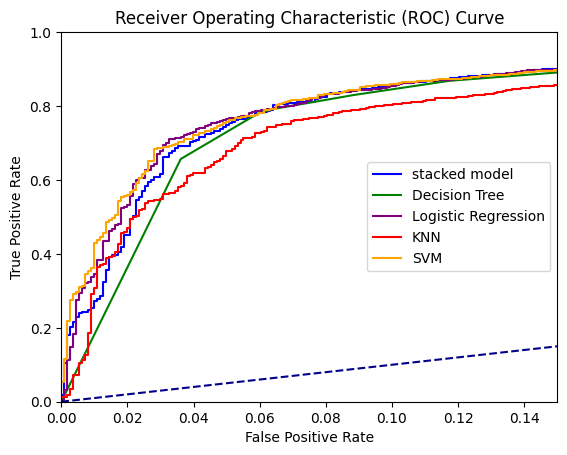

In [31]:
fprStacked, tprStacked, _ = metrics.roc_curve(y_test, yProbPred[:,1])
fprDecisionTree, tprDecisionTree, _ = metrics.roc_curve(y_test, y_Pred_DecisionTree[:,1])
fprLogisticRegression, tprLogisticRegression, _ = metrics.roc_curve(y_test, y_Pred_LogisticRegression[:,1])
fprKNN, tprKNN, _ = metrics.roc_curve(y_test, y_Pred_KNN[:,1])
fprSVM, tprSVM, _ = metrics.roc_curve(y_test, y_Pred_SVM[:,1])


plt.plot(fprStacked, tprStacked, color='blue', label = 'stacked model')
plt.plot(fprDecisionTree, tprDecisionTree, color='green', label = 'Decision Tree')
plt.plot(fprLogisticRegression, tprLogisticRegression, color='purple', label = 'Logistic Regression')
plt.plot(fprKNN, tprKNN, color='red', label = 'KNN')
plt.plot(fprSVM, tprSVM, color='orange', label = 'SVM')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.ylim(0, 1)
plt.xlim(0,0.15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

We can see that the stacked model performs very closely to the level of the logistic regression mmodel, although the logistic regression does seem to be performing better than the stacked model overall. This is likely to be because the other models perform less well than the logistic model and so therefore the average precision is lowered. However, looking at the performance metrics from before, we can see that for the '1' class we have precision of 93% and recall of 95%. This is really good as the aim of this model is for as many of the positive predictions to be correct as possible in order for people not to lose their money. Overall, it can be argued that this model has been quite successful.